## 1.数据预处理

In [1]:
#coding:utf-8
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from patsy import dmatrix 
from sklearn.ensemble import RandomForestClassifier 
from sklearn import linear_model 

In [2]:
ipos = pd.read_csv(r'ipo_data_0.csv', encoding='latin-1') 

In [3]:
#数据清洗
ipos = ipos.applymap(lambda x: x if not '$' in str(x) else x.replace('$', ''))
ipos = ipos.applymap(lambda x: x if not '%' in str(x) else x.replace('%', ''))

In [4]:
ipos.replace('N/C',0, inplace=True)

In [5]:

#更改数据类型
ipos['Date'] = pd.to_datetime(ipos['Date'])
ipos['Offer Price'] = ipos['Offer Price'].astype('float')
ipos['Opening Price'] = ipos['Opening Price'].astype('float')
ipos['1st Day Close'] = ipos['1st Day Close'].astype('float')
ipos['1st Day% Px Chng'] = ipos['1st Day% Px Chng'].astype('float')
ipos['$Chg Opening'] = ipos['$Chg Opening'].astype('float')
ipos['$Chg Close'] = ipos['$Chg Close'].astype('float')
ipos['Star Ratings'] = ipos['Star Ratings'].astype('float')

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 120-11-01 00:00:00

In [6]:
#data数据含异常值
ipos[ipos['Date'] == '11/120']


,Date,Issuer,Symbol,Lead/Joint-Lead Managers,Offer Price,Opening Price,1st Day Close,1st Day % Px Chng,$ Chg Opening,$ Chg Close,Star Ratings,Performed
1660,11/120,"Alon USA Partners, LP",ALDW,"Goldman, Sachs/ Credit Suisse/ Citigroup",16.00,17.00,18.40,15.00,1.00,2.40,1,NaN


In [8]:
#修改异常值，异常值正确的值应为2012/11/20
ipos.loc[1660, 'Date'] = '2012/11/20'




In [9]:
ipos['Date'] = pd.to_datetime(ipos['Date'])
ipos['Offer Price'] = ipos['Offer Price'].astype('float')
ipos['Opening Price'] = ipos['Opening Price'].astype('float')
ipos['1st Day Close'] = ipos['1st Day Close'].astype('float')
ipos['1st Day % Px Chng'] = ipos['1st Day % Px Chng'].astype('float')
ipos['$ Chg Opening'] = ipos['$ Chg Opening'].astype('float')
ipos['$ Chg Close'] = ipos['$ Chg Close'].astype('float')
ipos['Star Ratings'] = ipos['Star Ratings'].astype('float')

In [10]:
ipos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 12 columns):
Date                        2329 non-null datetime64[ns]
Issuer                      2329 non-null object
Symbol                      2329 non-null object
Lead/Joint-Lead Managers    2329 non-null object
Offer Price                 2329 non-null float64
Opening Price               2329 non-null float64
1st Day Close               2329 non-null float64
1st Day % Px Chng           2329 non-null float64
$ Chg Opening               2329 non-null float64
$ Chg Close                 2329 non-null float64
Star Ratings                2329 non-null float64
Performed                   259 non-null object
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 218.4+ KB


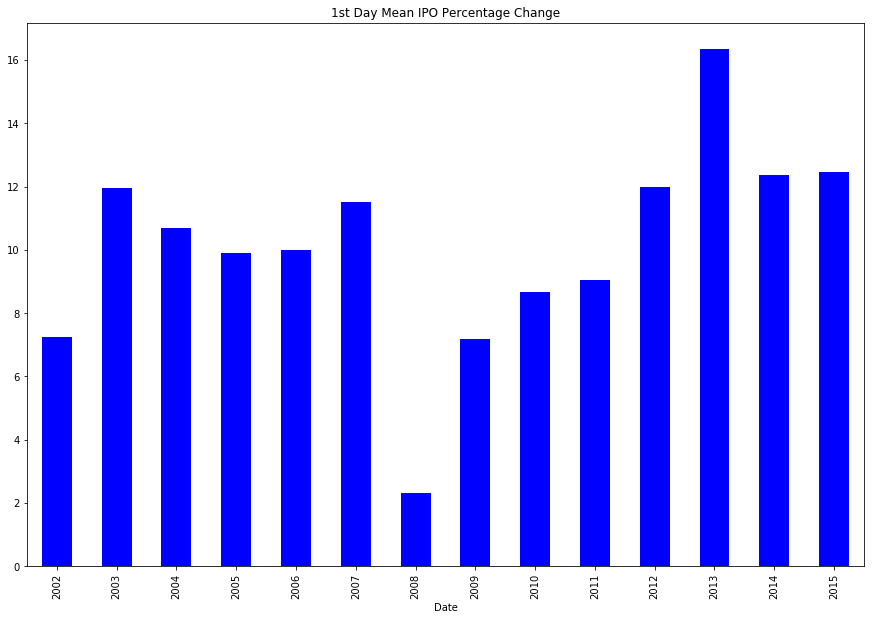

In [11]:
#探索数据，第一天的平均收益百分比
ipos.groupby(ipos['Date'].dt.year)['1st Day % Px Chng'].mean().plot(kind='bar', figsize=(15,10), color='b', title='1st Day Mean IPO Percentage Change')

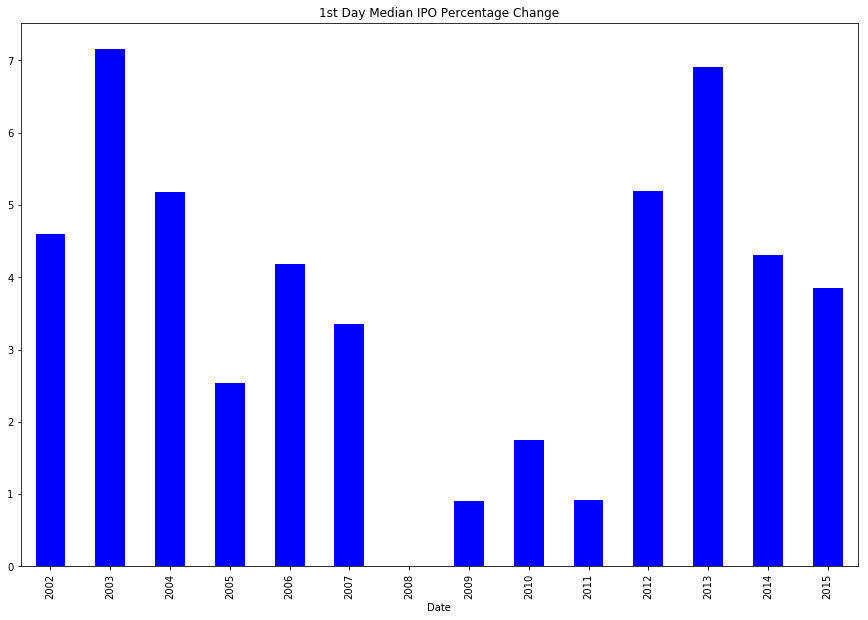

In [12]:
#第一天的中位数表现
ipos.groupby(ipos['Date'].dt.year)['1st Day % Px Chng'].median().plot(kind='bar', color='b',figsize=(15, 10),title='1st Day Median IPO Percentage Change')

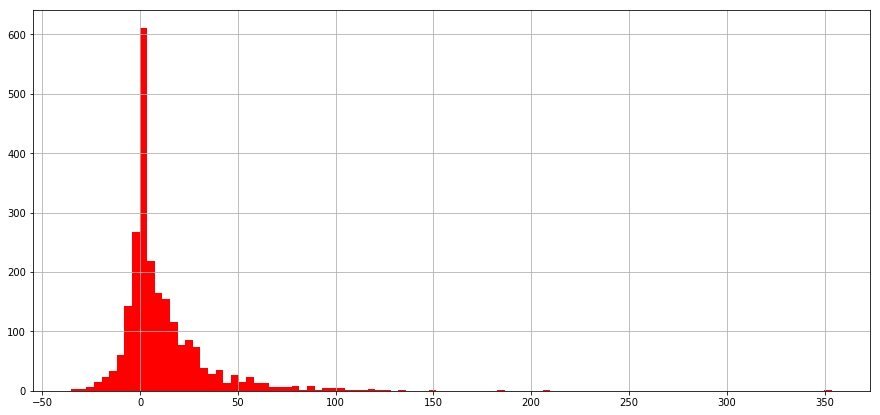

In [13]:
#使用柱状图绘制
ipos['1st Day % Px Chng'].hist(figsize=(15,7), bins=100, color='r')

In [14]:
#开盘价到收盘价的收益率
ipos['$ Chg Open to Close'] = ipos['$ Chg Close'] - ipos['$ Chg Opening']
ipos['% Chg Open to Close'] = ((ipos['$ Chg Open to Close'])/ipos['Opening Price']) * 100

In [15]:
ipos['% Chg Open to Close'].describe()

count    2329.000000
mean        0.799005
std         9.387540
min       -98.522167
25%        -2.823920
50%         0.000000
75%         3.686636
max       113.333333
Name: % Chg Open to Close, dtype: float64

由上面的数据可知最大跌幅达99%属于outlier，需进一步分析

In [17]:
#ipos[ipos['% Chg Open to Close'] == ipos['% Chg Open to Close'].min()]
#ipos['% Chg Open to Close'].sort_values()

In [18]:
#outlier处理
ipos.loc[440, '$ Chg Opening'] = .09
ipos.loc[1264, '$ Chg Opening'] = .01

In [19]:
ipos['% Chg Open to Close'].describe()

count    2329.000000
mean        0.799005
std         9.387540
min       -98.522167
25%        -2.823920
50%         0.000000
75%         3.686636
max       113.333333
Name: % Chg Open to Close, dtype: float64

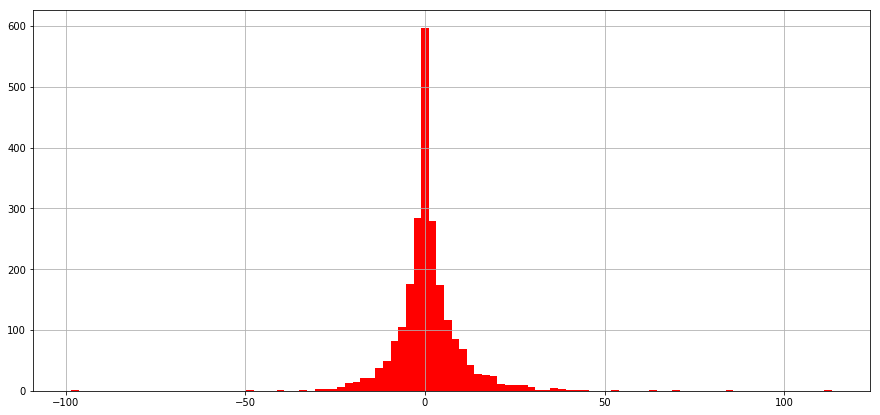

In [20]:
#绘制直方图
ipos['% Chg Open to Close'].hist(figsize=(15,7), bins=100, color='r')

In [21]:
ipos[ipos['Date']>='2015-01-01']['$ Chg Open to Close'].describe()

count    141.000000
mean       0.151702
std        2.603392
min       -6.160000
25%       -0.720000
50%        0.000000
75%        0.660000
max       20.040000
Name: $ Chg Open to Close, dtype: float64

In [22]:
ipos[ipos['Date']>='2015-01-01']['$ Chg Open to Close'].sum()

21.38999999999999

拆分一下盈利和亏损的交易

In [23]:
ipos[(ipos['Date']>='2015-01-01')&(ipos['$ Chg Open to Close']>0)]['$ Chg Open to Close'].describe()

count    70.000000
mean      1.454857
std       2.900963
min       0.010000
25%       0.215000
50%       0.665000
75%       1.315000
max      20.040000
Name: $ Chg Open to Close, dtype: float64

In [24]:
ipos[(ipos['Date']>='2015-01-01')&(ipos['$ Chg Open to Close']<0)]['$ Chg Open to Close'].describe()

count    63.000000
mean     -1.276984
std       1.394371
min      -6.160000
25%      -1.665000
50%      -0.860000
75%      -0.225000
max      -0.010000
Name: $ Chg Open to Close, dtype: float64

由以上分析可知，如果从2015年开始投资每一个ipo，一半会赚钱，一半会赔钱，整体是赚钱

## 2.特征工程

### 使用标普500指数的数据

In [80]:
sp = pd.read_csv(r'GSPC.csv') 
#sp.reset_index(drop=True, inplace=True)

In [83]:
sp.sort_values('Date', inplace=True)
sp.reset_index(drop=True, inplace=True)
sp['Date'] = pd.to_datetime(sp['Date']) 
ipos['Date'] = pd.to_datetime(ipos['Date'])

In [84]:
### 计算标普500  昨日收盘价相对于其七天前收盘价的变化百分比
def get_week_chg(ipo_dt):
    try:
        day_ago_idx =  sp[sp['Date']==str(ipo_dt.date())].index[0] - 1
        week_ago_idx = sp[sp['Date']==str(ipo_dt.date())].index[0] - 16
        chg = (sp.iloc[day_ago_idx]['Close'] - \
               sp.iloc[week_ago_idx]['Close'])/(sp.iloc[week_ago_idx]['Close'])
        return chg * 100
    except:
        print('error', ipo_dt.date())

ipos['SP Week Change'] = ipos['Date'].map(get_week_chg)

error 2009-08-01
error 2013-11-16
error 2015-02-21
error 2015-02-21


In [85]:
ipos.loc[1175, 'Date'] = pd.to_datetime('2009-08-12')
ipos.loc[1881, 'Date'] = pd.to_datetime('2013-11-06')
ipos.loc[2211, 'Date'] = pd.to_datetime('2015-05-21')
ipos.loc[2212, 'Date'] = pd.to_datetime('2015-05-21')

In [86]:
ipos['SP Week Change'] = ipos['Date'].map(get_week_chg)

添加一项新指标，标普500在ipo前一天收盘时到ipo首日开盘期间变化的百分比

In [87]:
def get_cto_chg(ipo_dt):
    try:
        today_open_idx =  sp[sp['Date']==str(ipo_dt.date())].index[0]
        yday_close_idx = sp[sp['Date']==str(ipo_dt.date())].index[0] - 1
        chg = (sp.iloc[today_open_idx]['Open'] - sp.iloc[yday_close_idx]['Close'])/(sp.iloc[yday_close_idx]['Close'])
        return chg * 100
    except:
        print('error', ipo_dt)

ipos['SP Close to Open Chg Pct'] = ipos['Date'].map(get_cto_chg)

整理承销商的数据

In [88]:
ipos['Lead Mgr'] = ipos['Lead/Joint-Lead Managers'].map(lambda x: x.split('/')[0])
ipos['Lead Mgr'] = ipos['Lead Mgr'].map(lambda x: x.strip())

In [89]:
for n in pd.DataFrame(ipos['Lead Mgr'].unique(), columns=['Name']).sort_values('Name')['Name']:
    print(n)

A.G. Edwards
A.G. Edwrads & Sons
AG Edwards
AG Edwards & Sons
AG Edwrads
Adams Harkness
Advest
Aegis Capital
Aegis Capital Corp
Aegis Capital Corp.
Anderson & Strudrick
Axiom Capital Management
BB&T Capital Markets
BMO Capital Markets
Baird
Baird, BMO Capital Markets, Janney Montgomery Scott
Banc of America
Banc of America Securities
Barclay Capital
Barclays
Barclays Capital
Bear Stearns
Bear Streans
BoA Merrill Lynch
BofA
BofA Merril Lynch
BofA Merrill Lych
BofA Merrill Lynch
Broadband Capital Management
Broadband Capital Management LLC
Burnham Securities
C&Co
C.E. Unterberg, Towbin
CIBC World Markets
CIBC Worldwide
CRT Capital
CRT Capital Group
CS First Boston
CSFirst Boston
Canaccord Genuity
Cantor Fitzgerald
Cantor Fitzgerald & Co.
Capital Growth Financial
Casimir Capital
Chardan Capital Markets
China Inter'l
China International
Cit
Citi
Citigroup
Cohen
Cohen & Company Capital Markets, LLC   I-Bankers Securities
Cowen
Cowen and Company
Craig-Hallum Capital
Credit Suisse
Credit Suis

In [90]:
ipos.loc[ipos['Lead Mgr'].str.contains('Hambrecht'),'Lead Mgr'] = 'WR Hambrecht+Co.'
ipos.loc[ipos['Lead Mgr'].str.contains('Edwards'), 'Lead Mgr'] = 'AG Edwards'
ipos.loc[ipos['Lead Mgr'].str.contains('Edwrads'), 'Lead Mgr'] = 'AG Edwards'
ipos.loc[ipos['Lead Mgr'].str.contains('Barclay'), 'Lead Mgr'] = 'Barclays'
ipos.loc[ipos['Lead Mgr'].str.contains('Aegis'), 'Lead Mgr'] = 'Aegis Capital'
ipos.loc[ipos['Lead Mgr'].str.contains('Deutsche'), 'Lead Mgr'] = 'Deutsche Bank'
ipos.loc[ipos['Lead Mgr'].str.contains('Suisse'), 'Lead Mgr'] = 'CSFB'
ipos.loc[ipos['Lead Mgr'].str.contains('CS.?F'), 'Lead Mgr'] = 'CSFB'
ipos.loc[ipos['Lead Mgr'].str.contains('^Early'), 'Lead Mgr'] = 'EarlyBirdCapital'
ipos.loc[325,'Lead Mgr'] = 'Maximum Captial'
ipos.loc[ipos['Lead Mgr'].str.contains('Keefe'), 'Lead Mgr'] = 'Keefe, Bruyette & Woods'
ipos.loc[ipos['Lead Mgr'].str.contains('Stan'), 'Lead Mgr'] = 'Morgan Stanley'
ipos.loc[ipos['Lead Mgr'].str.contains('P. Morg'), 'Lead Mgr'] = 'JP Morgan'
ipos.loc[ipos['Lead Mgr'].str.contains('PM'), 'Lead Mgr'] = 'JP Morgan'
ipos.loc[ipos['Lead Mgr'].str.contains('J\.P\.'), 'Lead Mgr'] = 'JP Morgan'
ipos.loc[ipos['Lead Mgr'].str.contains('Banc of'), 'Lead Mgr'] = 'Banc of America'
ipos.loc[ipos['Lead Mgr'].str.contains('Lych'), 'Lead Mgr'] = 'BofA Merrill Lynch'
ipos.loc[ipos['Lead Mgr'].str.contains('Merrill$'), 'Lead Mgr'] = 'Merrill Lynch'
ipos.loc[ipos['Lead Mgr'].str.contains('Lymch'), 'Lead Mgr'] = 'Merrill Lynch'
ipos.loc[ipos['Lead Mgr'].str.contains('A Merril Lynch'), 'Lead Mgr'] = 'BofA Merrill Lynch'
ipos.loc[ipos['Lead Mgr'].str.contains('Merril '), 'Lead Mgr'] = 'Merrill Lynch'
ipos.loc[ipos['Lead Mgr'].str.contains('BofA$'), 'Lead Mgr'] = 'BofA Merrill Lynch'
ipos.loc[ipos['Lead Mgr'].str.contains('SANDLER'), 'Lead Mgr'] = 'Sandler O\'neil + Partners'
ipos.loc[ipos['Lead Mgr'].str.contains('Sandler'), 'Lead Mgr'] = 'Sandler O\'Neil + Partners'
ipos.loc[ipos['Lead Mgr'].str.contains('Renshaw'), 'Lead Mgr'] = 'Rodman & Renshaw'
ipos.loc[ipos['Lead Mgr'].str.contains('Baird'), 'Lead Mgr'] = 'RW Baird'
ipos.loc[ipos['Lead Mgr'].str.contains('Cantor'), 'Lead Mgr'] = 'Cantor Fitzgerald'
ipos.loc[ipos['Lead Mgr'].str.contains('Goldman'), 'Lead Mgr'] = 'Goldman Sachs'
ipos.loc[ipos['Lead Mgr'].str.contains('Bear'), 'Lead Mgr'] = 'Bear Stearns'
ipos.loc[ipos['Lead Mgr'].str.contains('BoA'), 'Lead Mgr'] = 'BofA Merrill Lynch'
ipos.loc[ipos['Lead Mgr'].str.contains('Broadband'), 'Lead Mgr'] = 'Broadband Capital'
ipos.loc[ipos['Lead Mgr'].str.contains('Davidson'), 'Lead Mgr'] = 'DA Davidson'
ipos.loc[ipos['Lead Mgr'].str.contains('Feltl'), 'Lead Mgr'] = 'Feltl & Co.'
ipos.loc[ipos['Lead Mgr'].str.contains('China'), 'Lead Mgr'] = 'China International'
ipos.loc[ipos['Lead Mgr'].str.contains('Cit'), 'Lead Mgr'] = 'Citigroup'
ipos.loc[ipos['Lead Mgr'].str.contains('Ferris'), 'Lead Mgr'] = 'Ferris Baker Watts'
ipos.loc[ipos['Lead Mgr'].str.contains('Friedman|Freidman|FBR'), 'Lead Mgr'] = 'Friedman Billings Ramsey'
ipos.loc[ipos['Lead Mgr'].str.contains('^I-'), 'Lead Mgr'] = 'I-Bankers'
ipos.loc[ipos['Lead Mgr'].str.contains('Gunn'), 'Lead Mgr'] = 'Gunn Allen'
ipos.loc[ipos['Lead Mgr'].str.contains('Jeffer'), 'Lead Mgr'] = 'Jefferies'
ipos.loc[ipos['Lead Mgr'].str.contains('Oppen'), 'Lead Mgr'] = 'Oppenheimer'
ipos.loc[ipos['Lead Mgr'].str.contains('JMP'), 'Lead Mgr'] = 'JMP Securities'
ipos.loc[ipos['Lead Mgr'].str.contains('Rice'), 'Lead Mgr'] = 'Johnson Rice'
ipos.loc[ipos['Lead Mgr'].str.contains('Ladenburg'), 'Lead Mgr'] = 'Ladenburg Thalmann'
ipos.loc[ipos['Lead Mgr'].str.contains('Piper'), 'Lead Mgr'] = 'Piper Jaffray'
ipos.loc[ipos['Lead Mgr'].str.contains('Pali'), 'Lead Mgr'] = 'Pali Capital'
ipos.loc[ipos['Lead Mgr'].str.contains('Paulson'), 'Lead Mgr'] = 'Paulson Investment Co.'
ipos.loc[ipos['Lead Mgr'].str.contains('Roth'), 'Lead Mgr'] = 'Roth Capital'
ipos.loc[ipos['Lead Mgr'].str.contains('Stifel'), 'Lead Mgr'] = 'Stifel Nicolaus'
ipos.loc[ipos['Lead Mgr'].str.contains('SunTrust'), 'Lead Mgr'] = 'SunTrust Robinson'
ipos.loc[ipos['Lead Mgr'].str.contains('Wachovia'), 'Lead Mgr'] = 'Wachovia'
ipos.loc[ipos['Lead Mgr'].str.contains('Wedbush'), 'Lead Mgr'] = 'Wedbush Morgan'
ipos.loc[ipos['Lead Mgr'].str.contains('Blair'), 'Lead Mgr'] = 'William Blair'
ipos.loc[ipos['Lead Mgr'].str.contains('Wunderlich'), 'Lead Mgr'] = 'Wunderlich'
ipos.loc[ipos['Lead Mgr'].str.contains('Max'), 'Lead Mgr'] = 'Maxim Group'
ipos.loc[ipos['Lead Mgr'].str.contains('CIBC'), 'Lead Mgr'] = 'CIBC'
ipos.loc[ipos['Lead Mgr'].str.contains('CRT'), 'Lead Mgr'] = 'CRT Capital'
ipos.loc[ipos['Lead Mgr'].str.contains('HCF'),'Lead Mgr'] = 'HCFP Brenner'
ipos.loc[ipos['Lead Mgr'].str.contains('Cohen'), 'Lead Mgr']  = 'Cohen & Co.'
ipos.loc[ipos['Lead Mgr'].str.contains('Cowen'), 'Lead Mgr'] = 'Cowen & Co.'
ipos.loc[ipos['Lead Mgr'].str.contains('Leerink'), 'Lead Mgr']  = 'Leerink Partners'
ipos.loc[ipos['Lead Mgr'].str.contains('Lynch\xca'), 'Lead Mgr'] = 'Merrill Lynch'

In [ ]:
for n in pd.DataFrame(ipos['Lead Mgr'].unique(), columns=['Name']).sort_values('Name')['Name']:
    print(n)

In [91]:
ipos['Total Underwriters'] = ipos['Lead/Joint-Lead Managers'].map(lambda x: len(x.split('/')))

添加日期相关的特征

In [98]:
ipos['Week Day'] = ipos['Date'].dt.dayofweek.map({0:'Mon', 1:'Tues', 2:'Wed',\
                                                  3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'})
ipos['Month'] = ipos['Date'].dt.month.map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',7:'Jul',\
                                   8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})


发行价和开盘价之间的变化

In [99]:
ipos['Gap Open Pct'] = (ipos['$ Chg Opening'].astype('float')/ipos['Opening Price'].astype('float')) * 100

发行价和收盘价之间的变化

In [100]:
ipos['Open to Close Pct'] = (ipos['$ Chg Close'].astype('float') -\
                             ipos['$ Chg Opening'].astype('float'))/\
                             ipos['Opening Price'].astype('float') * 100

## 主要有如下几个特征
### 月份（  MonthMonth  ）
### 星期几（  Week DayWeek Day  ）
### 主要承销商（  Lead MgrLead Mgr  ）
### 承销商总数（  Total UnderwritersTotal Underwriters  ）
### 发行价到开盘价的差距百分比（  Gap Open PctGap Open Pct  ）
### 发行价到开盘价的美元变化量（  Chg OpeningChg Opening  ）
### 发行价（  Offer PriceOffer Price  ）
### 开盘价（  Opening PriceOpening Price  ）
### 标准普尔指数从收盘到开盘的变化百分比（  SP Close to Open Chg PctSP Close to Open Chg Pct  ）
### 标准普尔指数前一周的变化（  SP Week ChangeSP Week Change  ）

In [102]:
X = dmatrix('Month + Q("Week Day") + Q("Total Underwriters") + Q("Gap Open Pct") + Q("$ Chg Opening") + Q("Lead Mgr") + Q("Offer Price") + Q("Opening Price") + Q("SP Close to Open Chg Pct") + Q("SP Week Change")', data=ipos, return_type='dataframe')

## 使用逻辑回归进行预测

In [103]:
ipos[ipos['Date'].dt.year==2015]

,Date,Issuer,Symbol,Lead/Joint-Lead Managers,Offer Price,Opening Price,1st Day Close,1st Day % Px Chng,$ Chg Opening,$ Chg Close,...,% Chg Open to Close,SP week change,SP Week Change,SP Close to Open Chg Pct,Lead Mgr,Total Underwriters,Week Day,Month,Gap Open Pct,Open to Close Pct
2188,2015-01-16,Patriot National,PN,UBS Investment Bank/ BMO Capital Markets/ SunT...,14.00,13.49,13.50,-3.57,-0.51,-0.50,...,0.074129,None,-0.081232,-0.021079,UBS Investment Bank,3,Fri,Jan,-3.780578,0.074129
2189,2015-01-27,Zosano Pharma (ZSAN),ZSAN,Ladenburg Thalmann/ Roth Capital Partners,11.00,12.16,11.10,0.91,1.16,0.10,...,-8.717105,None,4.299573,-0.448697,Ladenburg Thalmann,2,Tues,Jan,9.539474,-8.717105
2190,2015-01-28,Ascendis Pharma A/S,ASND,BofA Merrill Lynch/ Leerink Partners,18.00,21.50,18.83,4.61,3.50,0.83,...,-12.418605,None,1.596878,0.137465,BofA Merrill Lynch,2,Wed,Jan,16.279070,-12.418605
2191,2015-01-29,Entellus Medical,ENTL,BofA Merrill Lynch/ Piper Jaffray,17.00,19.26,22.00,29.41,2.26,5.00,...,14.226376,None,-0.276431,0.014480,BofA Merrill Lynch,2,Thurs,Jan,11.734164,14.226376
2192,2015-01-29,Flex Pharma,FLKS,Jefferies/ Piper Jaffray,16.00,19.00,14.95,-6.56,3.00,-1.05,...,-21.315789,None,-0.276431,0.014480,Jefferies,2,Thurs,Jan,15.789474,-21.315789
2193,2015-01-29,Presbia PLC,LENS,Jefferies,10.00,9.25,8.15,-18.50,-0.75,-1.85,...,-11.891892,None,-0.276431,0.014480,Jefferies,1,Thurs,Jan,-8.108108,-11.891892
2194,2015-01-30,Avinger,AVGR,Canaccord Genuity/ Cowen,13.00,13.15,13.50,3.85,0.15,0.50,...,2.661597,None,0.984740,-0.094002,Canaccord Genuity,2,Fri,Jan,1.140684,2.661597
2195,2015-01-30,InfraREIT,HIFR,BofA Merrill Lynch/ Citigroup,23.00,27.10,26.60,15.65,4.10,3.60,...,-1.845018,None,0.984740,-0.094002,BofA Merrill Lynch,2,Fri,Jan,15.129151,-1.845018
2196,2015-01-30,Spark Therapeutics,ONCE,J.P. Morgan/ Credit Suisse,23.00,42.05,50.00,117.39,19.05,27.00,...,18.906064,None,0.984740,-0.094002,JP Morgan,2,Fri,Jan,45.303210,18.906064
2197,2015-01-30,Tracon Pharmaceuticals,TCON,Wells Fargo Securities/ Stifel,10.00,10.00,9.40,-6.00,0.00,-0.60,...,-6.000000,None,0.984740,-0.094002,Wells Fargo Securities,2,Fri,Jan,0.000000,-6.000000


In [104]:
# 2188 是第一个 2015 年数据的索引号，数据是按照日期排序的
X_train, X_test = X[:2188], X[2188:]

In [105]:
y_train = ipos['$ Chg Open to Close'][:2188].map(lambda x: 1 if x >= 1 else 0)

y_test = ipos['$ Chg Open to Close'][2188:].map(lambda x: 1 if x >= 1 else 0)

In [106]:
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [107]:
clf.score(X_test, y_test)

0.8226950354609929

In [108]:
ipos[(ipos['Date']>='2015-01-01')]['$ Chg Open to Close'].describe()

count    141.000000
mean       0.151702
std        2.603392
min       -6.160000
25%       -0.720000
50%        0.000000
75%        0.660000
max       20.040000
Name: $ Chg Open to Close, dtype: float64

In [109]:
pred_label = clf.predict(X_test)

results=[]
for pl, tl, idx, chg in zip(pred_label, y_test, y_test.index, ipos.iloc[y_test.index]['$ Chg Open to Close']):
    if pl == tl:
        results.append([idx, chg, pl, tl, 1])
    else:
        results.append([idx, chg, pl, tl, 0])

rf = pd.DataFrame(results, columns=['index', '$ chg', 'predicted', 'actual', 'correct'])
rf

,index,$ chg,predicted,actual,correct
0,2188,0.01,0,0,1
1,2189,-1.06,0,0,1
2,2190,-2.67,0,0,1
3,2191,2.74,0,1,0
4,2192,-4.05,0,0,1
5,2193,-1.10,0,0,1
6,2194,0.35,0,0,1
7,2195,-0.50,0,0,1
8,2196,7.95,0,1,0
9,2197,-0.60,0,0,1


In [110]:
rf[rf['predicted']==1]['$ chg'].describe()

count     7.000000
mean      3.311429
std       8.221031
min      -2.320000
25%      -1.235000
50%      -0.720000
75%       4.325000
max      20.040000
Name: $ chg, dtype: float64

Text(0.5,0,'Index')

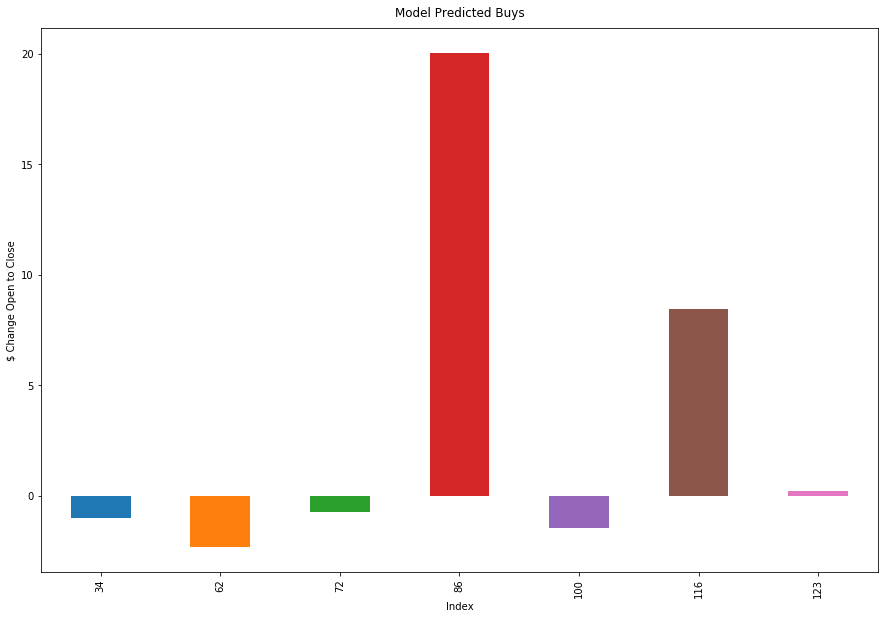

In [111]:
fig, ax = plt.subplots(figsize=(15,10))
rf[rf['predicted']==1]['$ chg'].plot(kind='bar')
ax.set_title('Model Predicted Buys', y=1.01)
ax.set_ylabel('$ Change Open to Close')
ax.set_xlabel('Index')

### 将阈值从1美元降低到0.25美元

In [112]:
X_train, X_test = X[:2188], X[2188:] 
y_train = ipos['$ Chg Open to Close'][:2188].map(lambda x: 1 if x >= .25 else 0) 
y_test = ipos['$ Chg Open to Close'][2188:].map(lambda x: 1 if x >= .25 else 0) 
clf = linear_model.LogisticRegression() 
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5957446808510638

In [113]:
pred_label = clf.predict(X_test)

results=[]
for pl, tl, idx, chg in zip(pred_label, y_test, y_test.index, ipos.iloc[y_test.index]['$ Chg Open to Close']):
    if pl == tl:
        results.append([idx, chg, pl, tl, 1])
    else:
        results.append([idx, chg, pl, tl, 0])

rf = pd.DataFrame(results, columns=['index', '$ chg', 'predicted', 'actual', 'correct'])
rf[rf['predicted']==1]['$ chg'].describe()

count    21.000000
mean      1.521905
std       5.734092
min      -6.160000
25%      -1.400000
50%       0.000000
75%       2.110000
max      20.040000
Name: $ chg, dtype: float64

由上面的数据得知准确率和平均值都下降了

### 使用随机森林分类器找出数据模型的重要的特征

([<matplotlib.axis.XTick at 0x1a269c1940>,
 <a list of 20 Text xticklabel objects>)

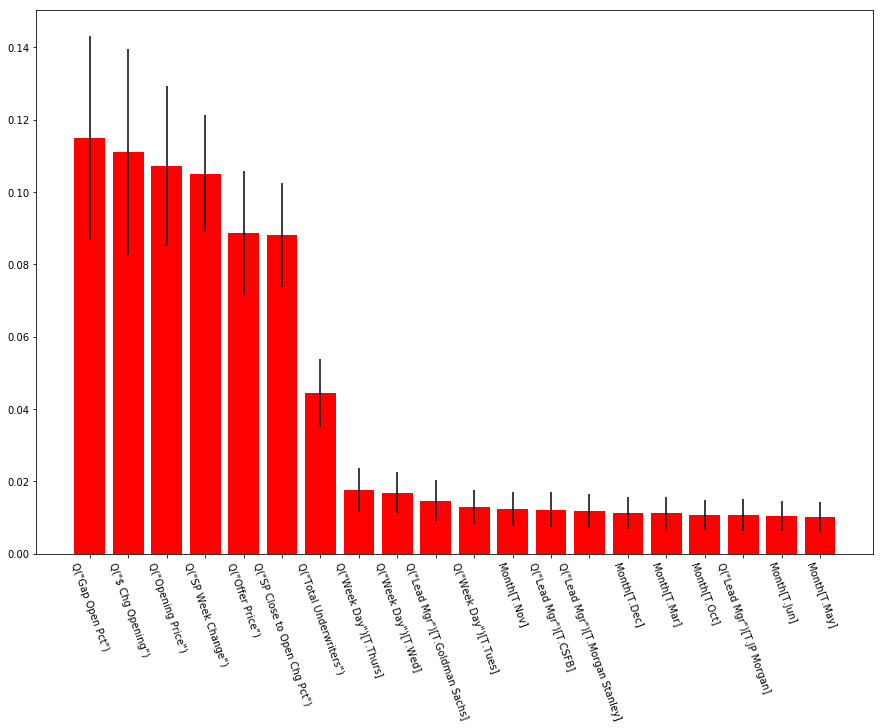

In [114]:
clf_rf = RandomForestClassifier(n_estimators=5000)
model = clf_rf.fit(X_train, y_train)
clf_rf.score(X_test, y_test)

f_importances = clf_rf.feature_importances_
f_names = X_train
f_std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)

zz = zip(f_importances, f_names, f_std)
zzs = sorted(zz, key=lambda x: x[0], reverse=True)

imps = [x[0] for x in zzs[:20]]
labels = [x[1] for x in zzs[:20]]
errs = [x[2] for x in zzs[:20]]

plt.subplots(figsize=(15,10))
plt.bar(range(20), imps, color="r", yerr=errs, align="center")
plt.xticks(range(20), labels, rotation=-70)